## Question 3

First, import cv2 to read .png files, and import plt to display them

In [1]:
import cv2
import matplotlib.pyplot as plt

Read these files and convert them from rgb to gray (Because there're 3 channels in every image)

In [2]:
hardware = cv2.imread(r'data/Hardware.png')
nuclei = cv2.imread(r'data/Nuclei.png')
orca = cv2.imread(r'data/Orca.png')

hardware_gray = cv2.cvtColor(hardware, cv2.COLOR_RGB2GRAY)
nuclei_gray = cv2.cvtColor(nuclei, cv2.COLOR_RGB2GRAY)
orca_gray = cv2.cvtColor(orca, cv2.COLOR_RGB2GRAY)

Here I define a function `get_histogram()`, which can return image's histogram conveniently:

In [3]:
def get_histogram(image):
    hist = [0] * 256

    for row in image:
        for p in row:
            hist[p] += 1

    return hist

The function `otsu_threshold_calculating` can calculate and return the Otsu threshold value.

In [4]:
def otsu_threshold_calculating(image):
    hist = get_histogram(image)

    s_max = [0, -10]
    N = len(image) * len(image[0])

    for t in range(256):
        w0 = sum(hist[:t]) / N
        w1 = sum(hist[t:]) / N

        m0 = sum([i * hist[i] for i in range(0, t)]) / sum(hist[:t]) if sum(hist[:t]) != 0 else 0
        m1 = sum([i * hist[i] for i in range(t, 256)]) / sum(hist[t:]) if sum(hist[t:]) != 0 else 0

        s = w0 * w1 * (m0 - m1) ** 2
        if s > s_max[1]:
            s_max[0] = t
            s_max[1] = s

    return s_max[0]

The function `isodata_threshold_calculating` can calculate and return the IsoData threshold value.

In [5]:
def isodata_threshold_calculating(image):
    t_old, t_new = 0, 128
    while t_old != t_new:
        lower = [pixel for row in image for pixel in row if pixel < t_new]
        upper = [pixel for row in image for pixel in row if pixel >= t_new]
        t_old = t_new
        t_new = (sum(lower) // len(lower) + sum(upper) // len(upper)) // 2
    return t_new

The function `triangle_threshold_calculating` can calculate and return the Triangle threshold value.

In [6]:
def triangle_threshold_calculating(image):
    hist = get_histogram(image)

    # get the max values' pixel value
    peak = max(hist)
    peak_idx = hist.index(peak)

    # find the position of the first and the last one 0
    left = next((i for i, value in enumerate(hist) if value != 0), None)
    right = len(hist) - 1 - next((i for i, value in enumerate(reversed(hist)) if value != 0), None)

    # if the peak in left, then inverse the histogram
    flip = False
    if peak_idx < len(hist) / 2:
        flip = True
        hist = hist[::-1]
        peak_idx = len(hist) - 1 - peak_idx
        left, right = len(hist) - 1 - right, len(hist) - 1 - left

    # calculate all the distances of the pixel point
    distances = []
    for i in range(peak_idx, right + 1):
        d = abs((right - peak_idx) * (hist[i] - hist[peak_idx]) -
                (hist[right] - hist[peak_idx]) * (i - peak_idx))
        distances.append(d)

    # find the max values' index
    max_distance_idx = distances.index(max(distances))
    threshold = max_distance_idx + peak_idx - 1

    # inverse it back if inversed before
    if flip:
        threshold = len(hist) - 1 - threshold

    return threshold

This function can apply the threshold values on images

In [7]:
def threshold_with_image(image, threshold_value):
    rows, cols = image.shape[0], image.shape[1]
    result_image = []
    for row in range(rows):
        result_image.append([0] * cols)

    for row in range(rows):
        for col in range(cols):
            if image[row][col] > threshold_value:
                result_image[row][col] = 255
            else:
                result_image[row][col] = 0

    return result_image

Get histograms from Hardware.png, Nuclei.png and Orca.png

In [8]:
hardware_histogram = get_histogram(hardware_gray)
nuclei_histogram = get_histogram(nuclei_gray)
orca_histogram = get_histogram(orca_gray)

Get the threshold image with Otsu

In [9]:
hardware_otsu = threshold_with_image(hardware_gray, otsu_threshold_calculating(hardware_gray))
nuclei_otsu = threshold_with_image(nuclei_gray, otsu_threshold_calculating(nuclei_gray))
orca_otsu = threshold_with_image(orca_gray, otsu_threshold_calculating(orca_gray))

Get the threshold image with IsoData

In [10]:
hardware_isodata = threshold_with_image(hardware_gray, isodata_threshold_calculating(hardware_gray))
nuclei_isodata = threshold_with_image(nuclei_gray, isodata_threshold_calculating(nuclei_gray))
orca_isodata = threshold_with_image(orca_gray, isodata_threshold_calculating(orca_gray))

Get the threshold image with Triangle

In [11]:
hardware_triangle = threshold_with_image(hardware_gray, triangle_threshold_calculating(hardware_gray))
nuclei_triangle = threshold_with_image(nuclei_gray, triangle_threshold_calculating(nuclei_gray))
orca_triangle = threshold_with_image(orca_gray, triangle_threshold_calculating(orca_gray))

Display the comparison result with plt, here I display them into a 3*5 grid, which shows original image, its histogram, 3 threshold images via Otsu, IsoData, Triangle in a row.

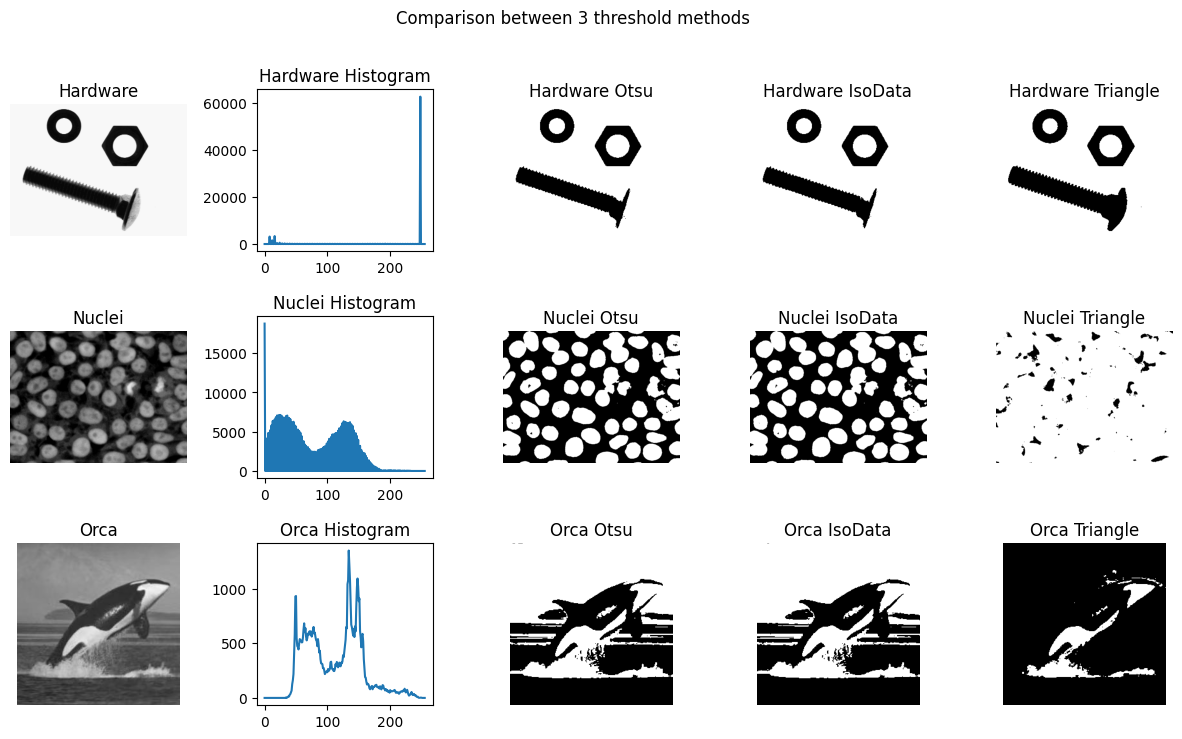

In [18]:
fig, a = plt.subplots(3, 5, figsize = (15, 8))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
fig.suptitle('Comparison between 3 threshold methods')

display_matrix = [
    [hardware, hardware_histogram, hardware_otsu, hardware_isodata, hardware_triangle],
    [nuclei, nuclei_histogram, nuclei_otsu, nuclei_isodata, nuclei_triangle],
    [orca, orca_histogram, orca_otsu, orca_isodata, orca_triangle]
]

title_matrix = [
    ['Hardware', 'Hardware Histogram', 'Hardware Otsu', 'Hardware IsoData', 'Hardware Triangle'],
    ['Nuclei', 'Nuclei Histogram', 'Nuclei Otsu', 'Nuclei IsoData', 'Nuclei Triangle'],
    ['Orca', 'Orca Histogram', 'Orca Otsu', 'Orca IsoData', 'Orca Triangle']
]

for i in range(3):
    for j in range(5):
        if j == 1:
            a[i][j].plot(display_matrix[i][j])
        else:
            a[i][j].axis('off')
            a[i][j].imshow(display_matrix[i][j], cmap='gray')
        a[i][j].set_title(title_matrix[i][j])

According to the results shown in the above figure, not all threshold segmentation algorithms are suitable for an image.
To the Hardware.png, because of the unbalanced distribution of gray value, all 3 methods could be used.
To the Nuclei.png and Orca.png, the results after Triangle Threshold processing are worse than the other 2.

So, choosing the appropriate threshold segmentation algorithm usually depends on the content of the image and the specific application scenario, but we could use the gray histogram to judge which method is the most appropriate and get the best result:

* If the histogram is bimodal (with two major peaks), this usually means that the image has two major clusters of pixels. In this case, Otsu's approach is a good choice, as it aims to find the optimal threshold between two peaks.
* For histograms without explicit peaks, you might consider using IsoData or iterative methods, as it works by iteratively estimating the average of the foreground and background.
* If the image contains significant edges and we want to get thresholds at the edges, consider using the Triangle method.
* ......

There're lots of methods of threshold, but the important step before that is histogram observation.

## Question 4

Read Laplace.png as cv2 image, and then convert it from rgb to gray.

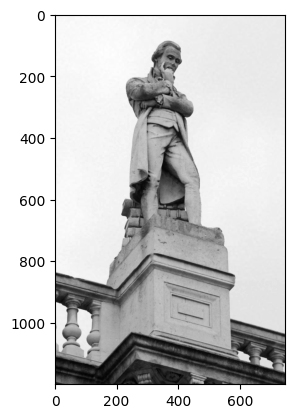

In [13]:
laplace = cv2.imread(r'data/Laplace.png')
laplace_gray = cv2.cvtColor(laplace, cv2.COLOR_BGR2GRAY)
plt.imshow(laplace_gray, cmap='gray')

In [14]:
# Laplacian Kernal definition
laplacian_kernal = [
    [1, 1, 1],
    [1, -8, 1],
    [1, 1, 1]
]

# get the shape of image
rows, cols = laplace_gray.shape

# initialization of egde detection result image
laplacian_image = []
for row in range(rows):
    laplacian_image.append([0] * cols)

# matrix calculation
for row in range(1, rows - 1):
    for col in range(1, cols - 1):
        sum = 0
        for y in range(-1, 2):
            for x in range(-1, 2):
                sum += laplacian_kernal[y + 1][x + 1] * laplace_gray[row + y][col + x]
        laplacian_image[row][col] = sum

The result of that maybe not clear.

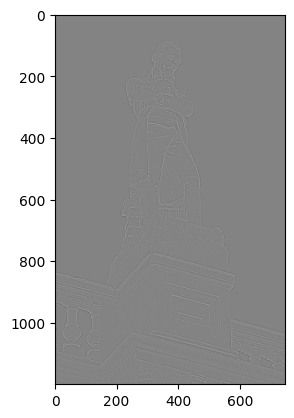

In [15]:
plt.imshow(laplacian_image, cmap='gray')